In [92]:
import sys
import warnings
from functools import lru_cache #https://www.geeksforgeeks.org/python-functools-lru_cache/

import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as st
import sklearn as skl

import torch
tt = torch.tensor
import torch.nn as nn
import pyro
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoLaplaceApproximation,
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean
)
from pyro.optim import Adam
from pyro.distributions import (
    Normal, 
    Uniform, 
    Beta, 
    Exponential, 
    LogNormal                            
)


from utils import HPDI, precis

In [93]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Jul 05 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

networkx  : 3.1
numpy     : 1.26.4
pyro      : 1.9.1
pandas    : 2.2.2
scipy     : 1.12.0
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
tqdm      : 4.66.4
torch     : 2.3.0
matplotlib: 3.9.0
sklearn   : 1.5.0

Watermark: 2.4.3



### Waffle House and marriage statistics (Dataset)
##### Description
Data for the individual States of the United States, describing number of Waffle House diners and various marriage and demographic facts.


- Location : State name
- Loc : State abbreviation
- Population : 2010 population in millions
- MedianAgeMarriage: 2005-2010 median age at marriage
- Marriage : 2009 marriage rate per 1000 adults
- Marriage.SE : Standard error of rate
- Divorce : 2009 divorce rate per 1000 adults
- Divorce.SE : Standard error of rate
- WaffleHouses : Number of diners
- South : 1 indicates Southern State
- Slaves1860 : Number of slaves in 1860 census
- Population1860 : Population from 1860 census
- PropSlaves1860 : Proportion of total population that were slaves in 1860

##### References
1860 census data from http://mapserver.lib.virginia.edu. Marriage and divorce rates from 2009 American Community Survey (ACS). Waffle House density data from wafflehouse.com (retrieved January 2012).

### Code 5.1
Load up the `WaffleDivorce` dataset and standardize the variables

In [94]:
waffle_df = pd.read_csv("data/WaffleDivorce.csv", sep=";")
waffle_df.sample(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
40,South Dakota,SD,0.81,25.6,20.1,2.64,10.9,2.50,0,0,0,4837,0.000000
29,New Jersey,NJ,8.79,27.7,14.8,0.59,6.1,0.46,0,0,18,672035,0.000027
27,Nebraska,NE,1.83,25.4,19.6,1.44,8.8,0.94,0,0,15,28841,0.000520


In [95]:
waffle_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Population,50.0,6.119600,6.876156,0.56,1.6350,4.435,6.6775,37.25
MedianAgeMarriage,50.0,26.054000,1.243630,23.20,25.3250,25.900,26.7500,29.70
Marriage,50.0,20.114000,3.797905,13.50,17.1250,19.700,22.1000,30.70
Marriage SE,50.0,1.399400,0.796975,0.39,0.8100,1.185,1.7675,3.92
Divorce,50.0,9.688000,1.820814,6.10,8.3000,9.750,10.9000,13.50
Divorce SE,50.0,0.961800,0.525367,0.24,0.5725,0.795,1.2575,2.50
WaffleHouses,50.0,32.340000,65.789587,0.00,0.0000,1.000,39.7500,381.00
South,50.0,0.280000,0.453557,0.00,0.0000,0.000,1.0000,1.00
Slaves1860,50.0,79378.340000,149730.921149,0.00,0.0000,0.000,80828.0000,490865.00
Population1860,50.0,628729.280000,781312.662599,0.00,43321.0000,407722.000,920977.0000,3880735.00


In [96]:
# Standardize variables
class WaffleDataset:
    def __init__(self, df):
        self.params = dict()
        for k1, k2 in (("MedianAgeMarriage", "A"), ("Divorce", "D"), ("Marriage", "M")):
            self.params[f"{k2}_mean"] = df[k1].mean()
            self.params[f"{k2}_std"] = df[k1].values.std()
            s = self.standardize(df[k1].values, k2)
            setattr(self, k2, df[k1].values) # raw values
            setattr(self, f"{k2}s", s) # standardized values
            
    def standardize(self, x, name):
        return (x - self.params[f"{name}_mean"])/self.params[f"{name}_std"]
    
    def unstandardize(self, x, name):
        return self.params[f"{name}_mean"] + self.params[f"{name}_std"] * x
    
wdata = WaffleDataset(waffle_df)

### Code 5.2
Standard deviation of age at marriage?

In [97]:
wdata.params["A_std"]

1.231131187160816

### Code 5.3
Do linear regression on $A$ and $D$

In [98]:
class RegressionModel:
    def __init__(self, x, y, prefix:str=""):
        self.x = x
        self.y = y
        self.name = prefix
        
    def __call__(self, x=None):
        nm = self.name + "/" if self.name != "" else ""
        a = pyro.sample(f"{nm}alpha", Normal(*tt((0., 0.2))))
        bA = pyro.sample(f"{nm}beta", Normal(*tt((0., 0.5))))
        sigma = pyro.sample(f"{nm}sigma", Exponential(tt(1.)))
        if x is None:
            mu = pyro.deterministic(f"{nm}mu", a + bA * self.x)
            with pyro.plate(nm, len(self.y)):
                pyro.sample(f"{nm}D", Normal(mu, sigma), obs=self.y)
        else:
            mu = pyro.deterministic(f"{nm}mu", a + bA * x)
            return pyro.sample(f"{nm}D", Normal(mu, sigma))
        
    def train(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self)
        svi = SVI(
            model=self,
            guide=self.guide,
            optim=Adam({"lr": 1e-3}),
            loss=Trace_ELBO(),
        )
        loss = list()
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

In [99]:
m5_1 = RegressionModel(tt(wdata.As), tt(wdata.Ds), prefix="m1")
loss = m5_1.train(1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

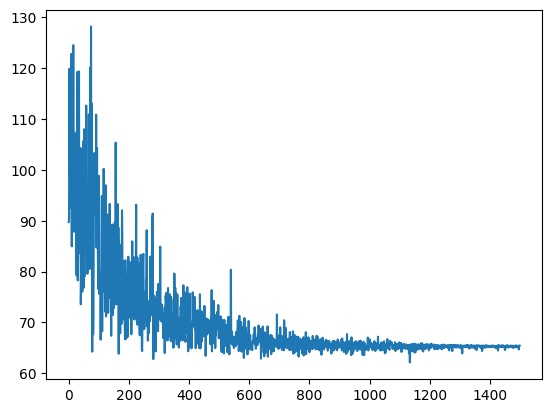

In [100]:
plt.plot(loss); plt.show()

### Code 5.4
Simulate from the prior

In [101]:
x = wdata.As
x = torch.linspace(x.min(), x.max(), 100)
samples_prior = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_1, {},
        num_samples=100,
        return_sites=("m1/alpha", "m1/beta")
    )(x).items()
}

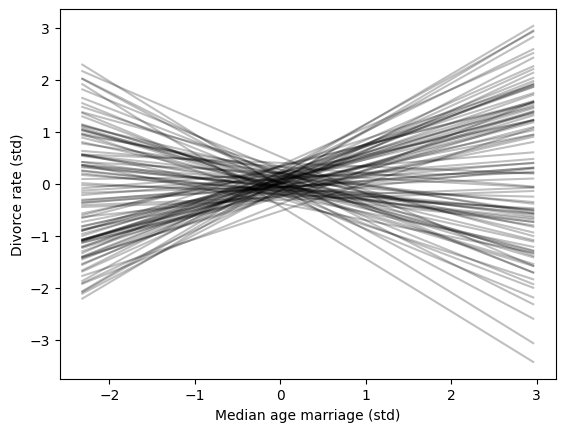

In [102]:
for a, b, in zip(samples_prior["m1/alpha"], samples_prior["m1/beta"]):
    y = a + b*x
    plt.plot(x, y, color="black", alpha=0.25)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.show()

### Code 5.5
Sample from posterior and draw the HPDI of the regression line

In [103]:
# Draw samples
x = wdata.As
x = torch.linspace(x.min(), x.max(), 100)
samples1 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_1,
        guide=m5_1.guide,
        num_samples=10000,
    )(x).items()
}

precis(samples1)

,mean,stddev,5.5%,94.5%
m1/alpha,-0.000775,0.09371,-0.151694,0.147077
m1/beta,-0.558507,0.102871,-0.722184,-0.393165
m1/sigma,0.823507,0.078181,0.703476,0.955138
m1/D,-0.179631,1.206921,-2.109551,1.736981
m1/mu,-0.180422,0.87981,-1.555681,1.169101


In [104]:
# Calculate HPDI
hpdi = dict()
for k in ["m1/mu", "m1/D"]:
    hpdi[k] = np.vstack([HPDI(samples1[k][:,i], 0.89) for i in range(100)])

[]

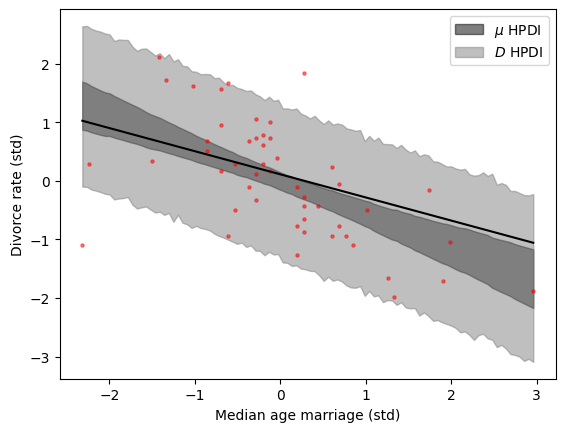

In [105]:
d = m5_1.guide()
# plot
y = []
for i in range(len(x)):
    y.append(d['m1/alpha'].item() + d['m1/beta'].item()*x[i])
plt.plot(x,y, "k")
plt.fill_between(x, *hpdi["m1/mu"].T, color="black", alpha=0.5, label="$\mu$ HPDI")
plt.fill_between(x, *hpdi["m1/D"].T, color="gray", alpha=0.5, label="$D$ HPDI")
plt.scatter(wdata.As, wdata.Ds, color="red", alpha=0.5, s=5)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.legend()
plt.plot()

### Code 5.6
Do the same thing but for the marriage rate/divorce rate

In [106]:
m5_2 = RegressionModel(tt(wdata.Ms), tt(wdata.Ds), prefix="m2")
loss = m5_2.train(1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

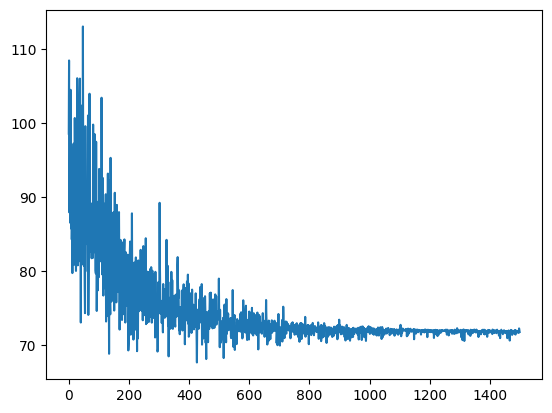

In [107]:
plt.plot(loss); plt.show()

In [108]:
# Draw samples
x = wdata.Ms
x = torch.linspace(x.min(), x.max(), 100)
samples2 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_2,
        guide=m5_2.guide,
        num_samples=10000,
    )(x).items()
}

precis(samples2)

,mean,stddev,5.5%,94.5%
m2/alpha,-0.004523,0.10287,-0.166848,0.160789
m2/beta,0.341981,0.11493,0.156957,0.524567
m2/sigma,0.953053,0.092724,0.814466,1.104337
m2/D,0.175592,1.077921,-1.537836,1.899637
m2/mu,0.176121,0.495598,-0.575299,0.999355


In [109]:
# Calculate HPDI
hpdi = dict()
for k in ("m2/mu", "m2/D"):
    hpdi[k] = np.vstack([HPDI(samples2[k][:,i], 0.89) for i in range(100)])

[]

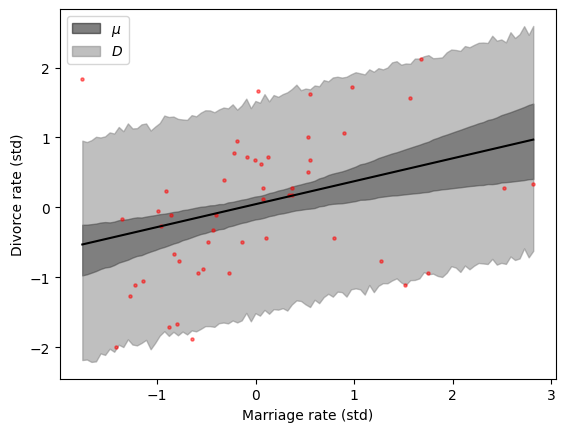

In [110]:
# plot
d = m5_2.guide()
# plot
y = []
for i in range(len(x)):
    y.append(d['m2/alpha'].item() + d['m2/beta'].item()*x[i])
plt.plot(x,y, "k")
plt.fill_between(x, *hpdi["m2/mu"].T, color="black", alpha=0.5, label="$\mu$")
plt.fill_between(x, *hpdi["m2/D"].T, color="gray", alpha=0.5, label="$D$")
plt.scatter(wdata.Ms, wdata.Ds, color="red", alpha=0.5, s=5)
plt.xlabel("Marriage rate (std)")
plt.ylabel("Divorce rate (std)")
plt.legend()
plt.plot()

### Code 5.7
Create the first DAG and draw it

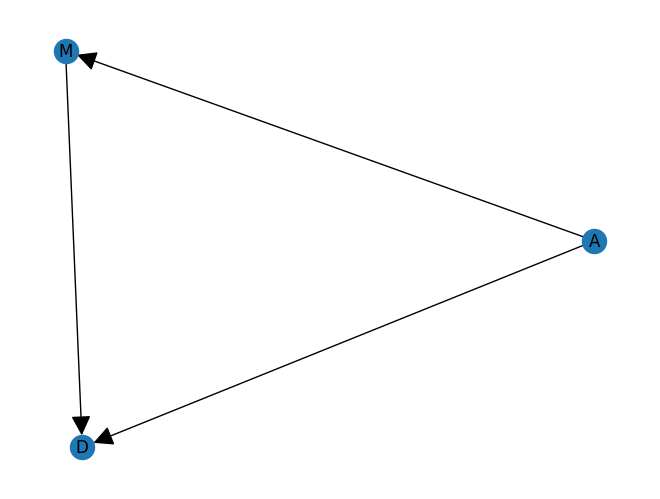

In [111]:
G1 = nx.DiGraph()
G1.add_nodes_from("ADM")
G1.add_edges_from([("A","D"), ("A","M"), ("M","D")])
nx.draw(G1, with_labels=True, arrowsize=30)

### Code 5.8/5.9
Make the second DAG and find the conditional independencies of both DAGs

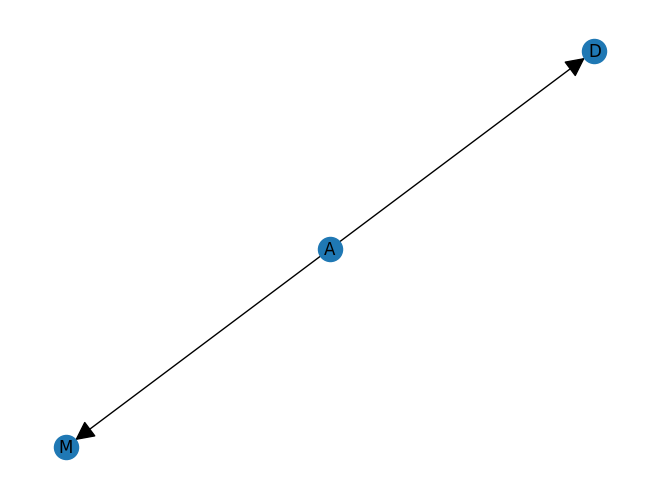

In [112]:
G2 = nx.DiGraph()
G2.add_nodes_from("ADM")
G2.add_edges_from([("A","D"), ("A","M")])
nx.draw(G2, with_labels=True, arrowsize=30)

I don't think `networkx` has a built-in way of computing conditional independencies, but it is clear that the first DAG has none, since any node is connected to any other node, and the first DAG only has $M \perp\!\!\perp D | A$ due to the fact that the only way to get from M to D is through A. We can roll our own algorithm ourselves.

Note that these are not the only DAGs we can draw using these variables. There are many more that should be considered, and looking at just these two likely isn't enough to determine the full causal diagram. In general, there could be feedback loops of some kind because we aren't taking time evolution into account, but then it wouldn't be a DAG anymore.

In [113]:
def independent(G, n1, n2, n3=None):
    """Computes whether n1 and n2 are independent given n3 on the DAG G
    
    Can find a decent exposition of the algorithm at http://web.mit.edu/jmn/www/6.034/d-separation.pdf
    """
    from networkx.algorithms.moral import moral_graph
    from networkx.algorithms.dag import ancestors
    from networkx.algorithms.shortest_paths import has_path
    if n3 is None:
        n3 = set()
    elif isinstance(n3, (int, str)):
        n3 = set([n3])
    elif not isinstance(n3, set):
        n3 = set(n3)
    # Construct the ancestral graph of n1, n2, and n3
    a = ancestors(G, n1) | ancestors(G, n2) | {n1, n2} | n3
    G = G.subgraph(a)
    # Moralize the graph
    M = moral_graph(G)
    # Remove n3 (if applicable)
    M.remove_nodes_from(n3)
    # Check that path exists between n1 and n2
    return not has_path(M, n1, n2)

def conditional_independencies(G):
    """Finds all conditional independencies in the DAG G
    
    Only works when conditioning on a single node at a time. Returns
    a list of tuples (n1, n2, n3) where n1 is independent of n2 when
    conditioned on n3.
    """
    tuples = []
    for i1, n1 in enumerate(G.nodes):
        for i2, n2 in enumerate(G.nodes):
            if i1 >= i2:
                continue
            for n3 in G.nodes:
                try:
                    if independent(G, n1, n2, n3):
                        tuples.append((n1, n2, n3))
                except:
                    pass
    return tuples

def marginal_independencies(G):
    """Finds all marginal independencies in the DAG G
    
    Returns a list of tuples (n1, n2) where n1 is marginally
    independent of n2.
    """
    tuples = []
    for i1, n1 in enumerate(G.nodes):
        for i2, n2 in enumerate(G.nodes):
            if i1 >= i2:
                continue
            try:
                if independent(G, n1, n2, {}):
                    tuples.append((n1, n2, {}))
            except:
                pass
    return tuples

In [114]:
conditional_independencies(G1)

[]

In [115]:
conditional_independencies(G2)

[('D', 'M', 'A')]

### Code 5.10
Perform multiple linear regression on the divorce rate using both age at marriage and marriage rate as predictors

In [116]:
class MultipleRegression:
    def __init__(self, X, y, prefix=""):
        self.X = X
        self.y = y
        self.n_vars = int(X.shape[-1])
        self.name = prefix
        
    def __call__(self, X=None):
        nm = self.name + "/" if self.name != "" else ""
        alpha = pyro.sample(f"{nm}alpha", Normal(*tt((0., 0.2)).double()))
        sigma = pyro.sample(f"{nm}sigma", Exponential(tt(1.).double()))
        beta = pyro.sample(f"{nm}beta", Normal(*tt((0., 0.5)).double())\
                           .expand([self.n_vars])\
                           .to_event(1)) # notice to_event here
        if X is None:
            mu = pyro.deterministic(f"{nm}mu", alpha + torch.matmul(self.X, beta))
            with pyro.plate(nm, len(self.y)):
                pyro.sample(f"{nm}D", Normal(mu, sigma), obs=self.y)
        else:
            mu = pyro.deterministic(f"{nm}mu", alpha + torch.matmul(X, beta))
            return pyro.sample(f"{nm}D", Normal(mu, sigma))
        
    def train(self, n_steps):
#         self.guide = AutoLaplaceApproximation(self)
        self.guide = AutoMultivariateNormal(self)
        pyro.clear_param_store()
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = list()
        for _ in tqdm.notebook.tnrange(n_steps):
            step_loss = svi.step()
            loss.append(step_loss)
#         self.guide = self.guide.laplace_approximation(self.X)
        return loss

  0%|          | 0/3000 [00:00<?, ?it/s]

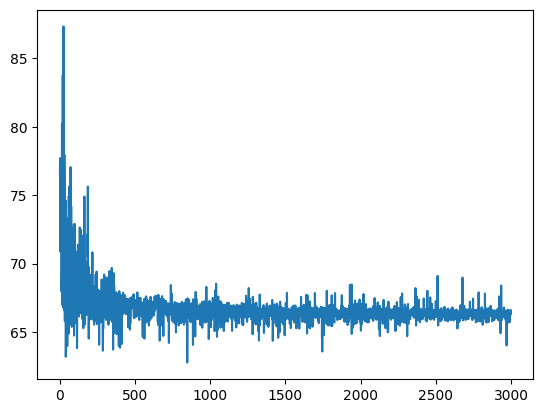

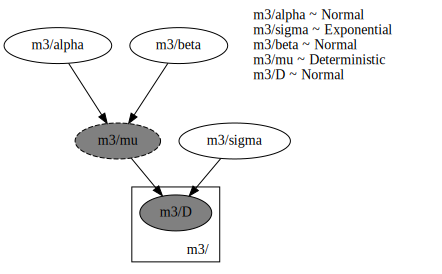

In [117]:
X = tt([wdata.As, wdata.Ms]).T.double()
y = tt(wdata.Ds).double()
m5_3 = MultipleRegression(X, y, prefix="m3")
loss = m5_3.train(3000)
plt.plot(loss); plt.show()
pyro.render_model(m5_3, 
                  model_args=(),     
                  render_params=True,
                  render_distributions=True,
                  render_deterministic=True)

### Code 5.11
Plot the coefficients' HPDI for the various models

In [118]:
samples3 = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_3,
        guide=m5_3.guide,
        num_samples=10000,
    )().items()
}
print(samples3)
precis(samples3)

{'m3/alpha': array([[ 0.21426793],
       [ 0.17761869],
       [-0.13955096],
       ...,
       [-0.06290003],
       [ 0.00430745],
       [ 0.00640182]]), 'm3/sigma': array([[0.75808072],
       [0.83376419],
       [0.77030451],
       ...,
       [0.78914539],
       [0.84489834],
       [0.79784453]]), 'm3/beta': array([[[-0.50971067,  0.02013078]],

       [[-0.62484743,  0.05036016]],

       [[-0.44270651, -0.06992409]],

       ...,

       [[-0.56040371, -0.17272691]],

       [[-0.45112343,  0.01299907]],

       [[-0.34486367,  0.18082504]]]), 'm3/mu': array([[[ 0.52689809,  0.5993549 ,  0.32042444, ...,  0.66181216,
          0.09681701,  1.03853831]],

       [[ 0.56145525,  0.68989789,  0.30902507, ...,  0.74050624,
          0.01373215,  1.26039181]],

       [[ 0.12998294,  0.05807303, -0.05167352, ...,  0.20066464,
         -0.17381591,  0.33025504]],

       ...,

       [[ 0.27636541,  0.05542557,  0.04417421, ...,  0.32104115,
         -0.04100499,  0.29469584]],

,mean,stddev,5.5%,94.5%
m3/alpha,0.008988,0.105294,-0.156088,0.179779
m3/sigma,0.827223,0.084662,0.698723,0.970439
m3/beta,-0.334192,0.302388,-0.778496,0.106855
m3/mu,0.008988,0.583296,-1.006565,0.860838
m3/D,-0.0,1.0,-1.713163,1.726478


In [119]:
summary = {
    1: {
        "beta_A": {
            "hpdi": HPDI(samples1["m1/beta"], 0.89),
            "mean": samples1["m1/beta"].mean(),
        },
        "beta_M": None,
    },
    2: {
        "beta_M": {
            "hpdi": HPDI(samples2["m2/beta"], 0.89),
            "mean": samples2["m2/beta"].mean(),
        },
        "beta_A": None,
    },
    3: {
        "beta_A": {
            "hpdi": HPDI(samples3["m3/beta"][:,0, 0], 0.89),
            "mean": samples3["m3/beta"][:,0, 0].mean(),
        },
        "beta_M": {
            "hpdi": HPDI(samples3["m3/beta"][:, 0, 1], 0.89),
            "mean": samples3["m3/beta"][:, 0, 1].mean(),
        },
    },
}
print(summary)

{1: {'beta_A': {'hpdi': (-0.72615397, -0.39833817), 'mean': -0.55850744}, 'beta_M': None}, 2: {'beta_M': {'hpdi': (0.15800542, 0.52490824), 'mean': 0.34198055}, 'beta_A': None}, 3: {'beta_A': {'hpdi': (-0.8274678717801994, -0.35875672507317125), 'mean': -0.5991298753290787}, 'beta_M': {'hpdi': (-0.29098393445059867, 0.16301019809795003), 'mean': -0.06925334162008398}}}


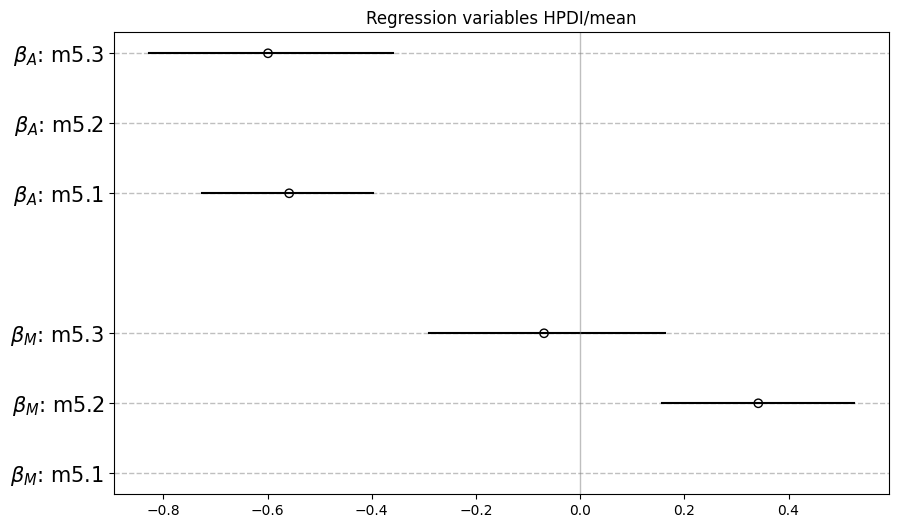

In [120]:
plt.figure(figsize=(10, 6))
ticks = list()
for i, model in summary.items():
    for var, vals in model.items():
        if var == "beta_A":
            y = i + 4
        else:
            y = i
        plt.axhline(y, color="gray", linestyle="--", linewidth=1, alpha=0.5)
        ticks.append((y, fr"$\{var}$"f": m5.{i}"))
        if vals is None: continue
        for k, v in vals.items():
            if k == "mean":
                plt.scatter(v, y, facecolor="none", edgecolor="black")
            elif k == "hpdi":
                plt.plot(v, [y, y], color="black")
plt.axvline(0, color="gray", linewidth=1, alpha=0.5)
plt.yticks(*zip(*ticks), fontsize=15)
plt.title("Regression variables HPDI/mean")
plt.show()

### Code 5.12
The inferred DAG implies a simple simulation to reproduce the dataset:

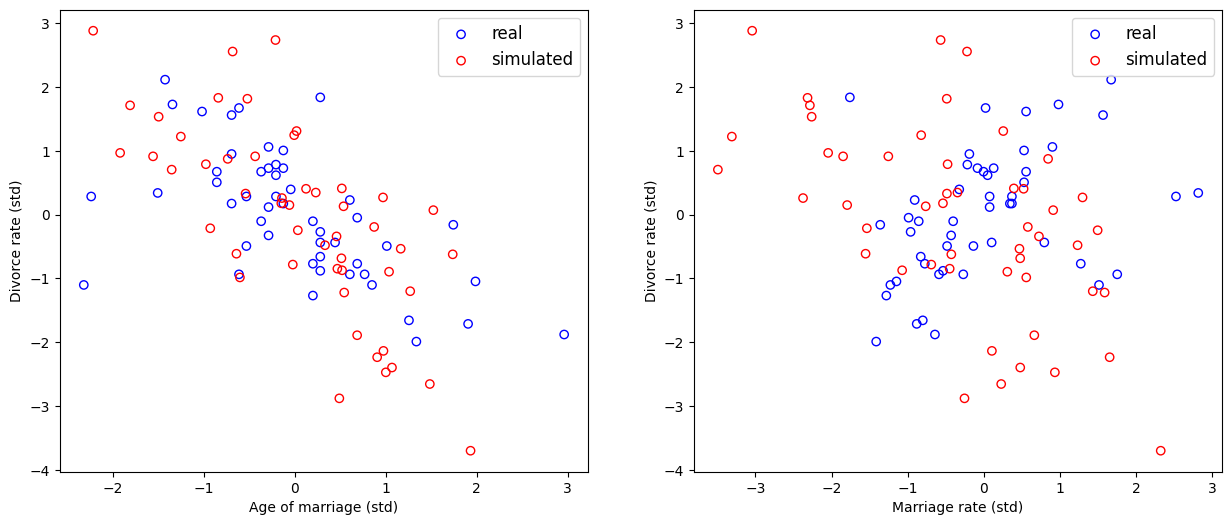

In [180]:
N = 50
# example of M ← A → D
age = np.random.randn(N)
mar = np.random.randn(N) + age
div = np.random.randn(N) - age

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.sca(axes[0])
plt.scatter(wdata.As, wdata.Ds, edgecolor="blue", facecolor="none", label="real")
plt.scatter(age, div, edgecolor="red", facecolor="none", label="simulated")
plt.xlabel("Age of marriage (std)")
plt.ylabel("Divorce rate (std)")
plt.legend(fontsize=12)
plt.sca(axes[1])
plt.scatter(wdata.Ms, wdata.Ds, edgecolor="blue", facecolor="none", label="real")
plt.scatter(mar, div, edgecolor="red", facecolor="none", label="simulated")
plt.xlabel("Marriage rate (std)")
plt.ylabel("Divorce rate (std)")
plt.legend(fontsize=12)
plt.show()

### Code 5.13-5.14
Regress the marriage rate as a linear function of the age at marriage and vice versa, so that we can use it to build a _predictor residual plot_

torch.Size([50]) torch.Size([50])


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

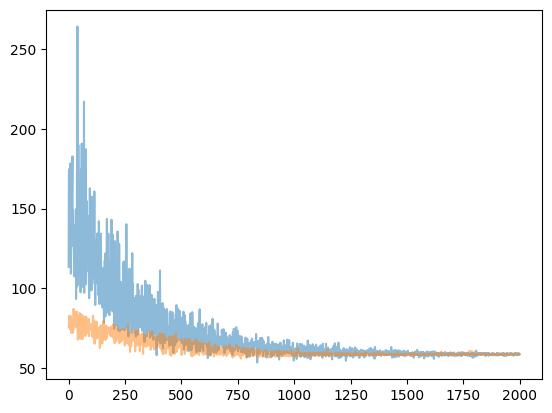

In [122]:
a = tt(wdata.As).double()
m = tt(wdata.Ms).double()
print(a.shape, m.shape)

m5_4_m = RegressionModel(a, m, prefix="M_res")

loss = m5_4_m.train(2000)
plt.plot(loss, alpha=0.5)
samples_m = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_m,
        guide=m5_4_m.guide,
        num_samples=1000,
        return_sites=("M_res/mu",)
    )(a).items()
}

m5_4_a = RegressionModel(m, a, prefix="A_res")

loss = m5_4_a.train(2000)
plt.plot(loss, alpha=0.5); plt.show()
samples_a = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_a,
        guide=m5_4_a.guide,
        num_samples=1000,
        return_sites=("A_res/mu",)
    )(m).items()
}

The _residuals_ are computed by subtracting the observed marriage rate from the predicted rate (the mean $\mu$), based on the model above

/tmp/ipykernel_4592/3110865348.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m5_4_D_Ares = RegressionModel(tt(res).double(), tt(wdata.Ds[idx_res]).double(), prefix="D_Ares")


  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_4592/3110865348.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m5_4_D_Mres = RegressionModel(tt(res).double(), tt(wdata.Ds[idx_res]).double(), prefix="D_Mres")


  0%|          | 0/2000 [00:00<?, ?it/s]

(50, 2)
(50, 2)


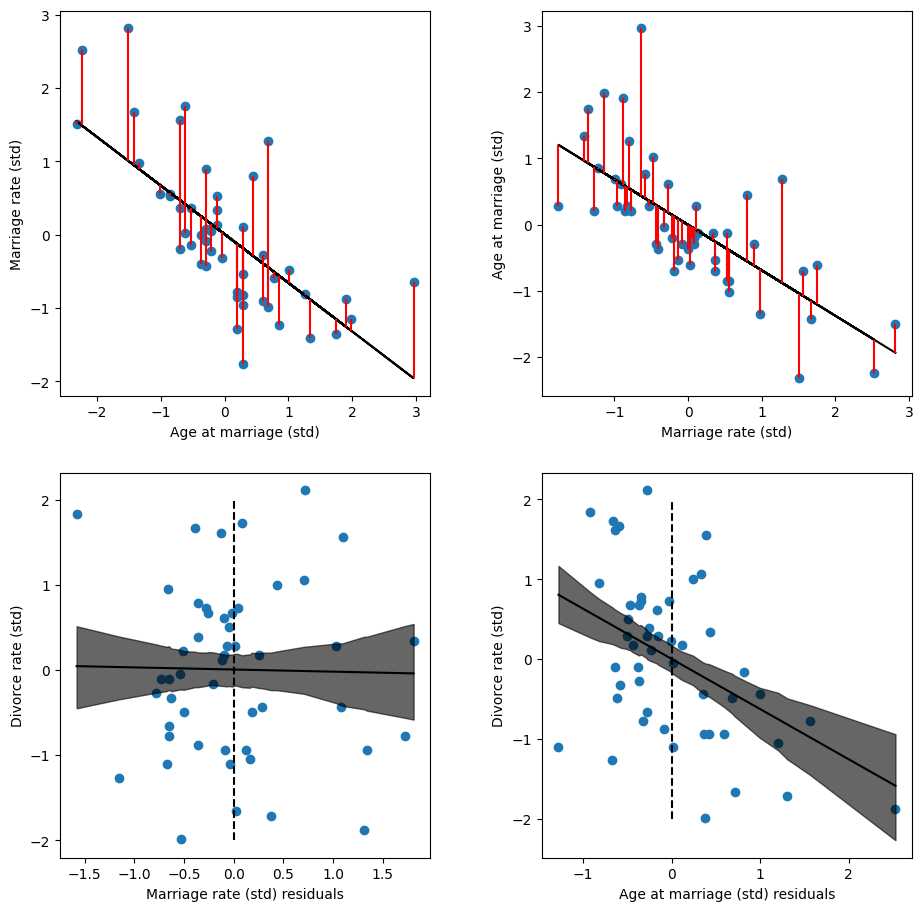

In [123]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11))
# Plot of age vs marriage rate
plt.sca(axes[0,0])
plt.scatter(a, m)
#print(samples_m["M_res/mu"].shape)
mu_m = samples_m["M_res/mu"].mean(axis=0)
#print(mu_m.shape)
plt.plot(a, mu_m, color="black")
plt.vlines(a, mu_m, m, color='r')
plt.xlabel("Age at marriage (std)")
plt.ylabel("Marriage rate (std)")
# Plot of marriage vs age
plt.sca(axes[0,1])
plt.scatter(m, a)
#print(samples_a["A_res/mu"].shape)
mu_a = samples_a["A_res/mu"].mean(axis=0)
#print(mu_a.shape)
plt.plot(m, mu_a, color="black")
plt.vlines(m, mu_a, a, color='r')
plt.xlabel("Marriage rate (std)")
plt.ylabel("Age at marriage (std)")

# Marriage residuals vs divorce
plt.sca(axes[1,0])
res = m - mu_m
idx_res = np.argsort(res)
res = res[idx_res]
plt.scatter(res, wdata.Ds[idx_res])

m5_4_D_Ares = RegressionModel(tt(res).double(), tt(wdata.Ds[idx_res]).double(), prefix="D_Ares")
loss = m5_4_D_Ares.train(2000)
samples_D_Ares = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_D_Ares,
        guide=m5_4_D_Ares.guide,
        num_samples=1000,
        return_sites=("D_Ares/mu",)
    )(res).items()
}

mu_D_Ares = samples_D_Ares["D_Ares/mu"].mean(axis=0)
n_points = samples_D_Ares["D_Ares/mu"].shape[1]
mu_D_Ares_HPDI = np.vstack([HPDI(samples_D_Ares["D_Ares/mu"][:,i], prob=0.89) for i in range(n_points)])
#print(mu_D_Ares_HPDI.shape)
plt.plot(res, mu_D_Ares, color="black")
plt.fill_between(res, mu_D_Ares_HPDI[:,1] , mu_D_Ares_HPDI[:,0], color="black", alpha=0.6, label=r"$\mu_i$ HPDI")
plt.xlabel("Marriage rate (std) residuals")
plt.ylabel("Divorce rate (std)")
plt.vlines(0, -2, 2, color='k', linestyle='--')

# Age residuals vs divorce
plt.sca(axes[1,1])
res = a - mu_a
idx_res = np.argsort(res)
res = res[idx_res]
plt.scatter(res, wdata.Ds[idx_res])

m5_4_D_Mres = RegressionModel(tt(res).double(), tt(wdata.Ds[idx_res]).double(), prefix="D_Mres")
loss = m5_4_D_Mres.train(2000)
samples_D_Mres = {
    k: v.detach().numpy()
    for k, v in Predictive(
        m5_4_D_Mres,
        guide=m5_4_D_Mres.guide,
        num_samples=1000,
        return_sites=("D_Mres/mu",)
    )(res).items()
}
n_points = samples_D_Mres["D_Mres/mu"].shape[1]
mu_D_Mres_HPDI = np.vstack([HPDI(samples_D_Mres["D_Mres/mu"][:,i], prob=0.89) for i in range(n_points)])
print(mu_D_Mres_HPDI.shape)

mu_D_Mres = samples_D_Mres["D_Mres/mu"].mean(axis=0)
n_points = samples_D_Mres["D_Mres/mu"].shape[1]
mu_D_Mres_HPDI = np.vstack([HPDI(samples_D_Mres["D_Mres/mu"][:,i], prob=0.89) for i in range(n_points)])
print(mu_D_Mres_HPDI.shape)
plt.plot(res, mu_D_Mres, color="black")
plt.fill_between(res, mu_D_Mres_HPDI[:,1] , mu_D_Mres_HPDI[:,0], color="black", alpha=0.6, label=r"$\mu_i$ HPDI")
plt.xlabel("Age at marriage (std) residuals")
plt.ylabel("Divorce rate (std)")
plt.vlines(0, -2, 2, color='k', linestyle='--')
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 5.15-5.16
Sample from the posterior of the multivariate regression and compare (mean) predictions vs. the actuals

(50,)


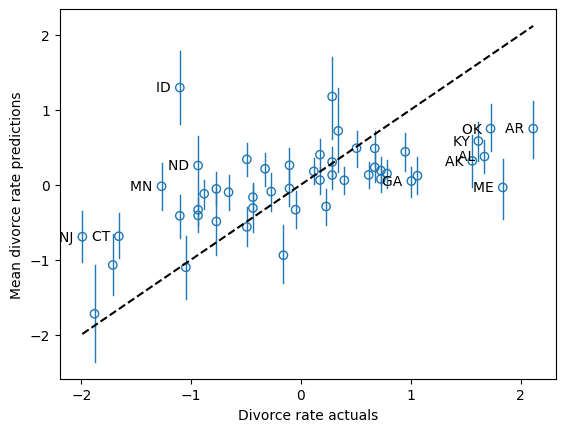

In [124]:
# Plot regression mean @ data
s = samples3["m3/mu"].squeeze()
mu = s.mean(axis=0)
print(mu.shape)
plt.scatter(wdata.Ds, mu, facecolor="none", edgecolor="C0")
# Plot mu HPDI for each datapoint
#print([x.shape for x in s.T])
mu_hpdi = np.array([HPDI(x, 0.89) for x in s.T])
for q, d in zip(mu_hpdi, wdata.Ds):
    plt.plot((d, d), q, color="C0", linewidth=1)
# "breakeven" line

x = np.linspace(wdata.Ds.min(), wdata.Ds.max())
plt.plot(x, x, color="black", linestyle="--")
# Labels for largest residuals
idx = np.argsort(abs(mu - wdata.Ds))[-12:]
label = waffle_df.iloc[idx]["Loc"].values
for l, i in zip(label, idx):
    plt.text(wdata.Ds[i], mu[i], l+"  ", verticalalignment="center", horizontalalignment="right")
plt.xlabel("Divorce rate actuals")
plt.ylabel("Mean divorce rate predictions")
plt.show()

### Code 5.18
Simulate how a real predictor influences a spurious predictor, then show how multiple regression can control for the spurious predictor

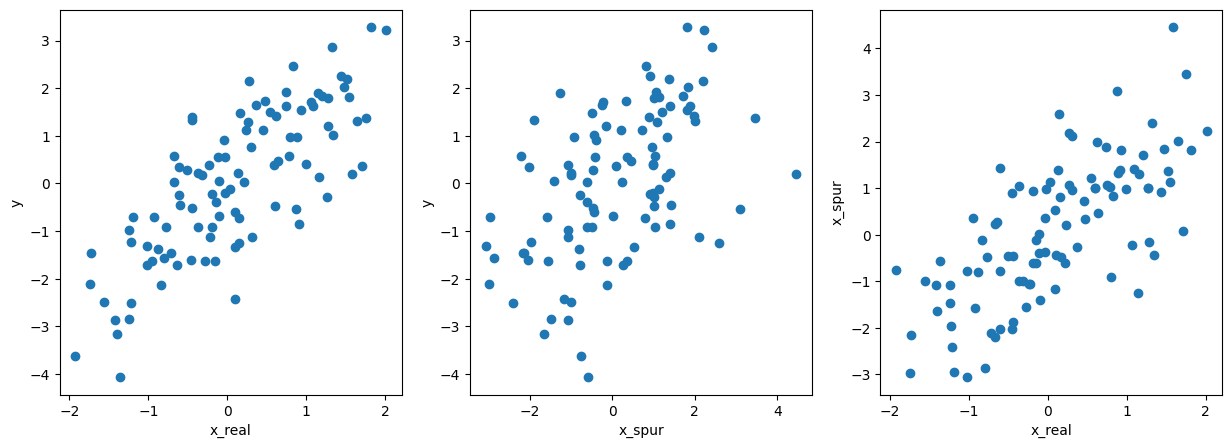

In [125]:
N = 100
x_real = np.random.randn(N)
x_spur = np.random.randn(N) + x_real
y = np.random.randn(N) + x_real
# visualize correlations
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
plt.sca(axes[0])
plt.scatter(x_real, y)
plt.xlabel("x_real")
plt.ylabel("y")
plt.sca(axes[1])
plt.scatter(x_spur, y)
plt.xlabel("x_spur")
plt.ylabel("y")
plt.sca(axes[2])
plt.scatter(x_real, x_spur)
plt.xlabel("x_real")
plt.ylabel("x_spur")
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

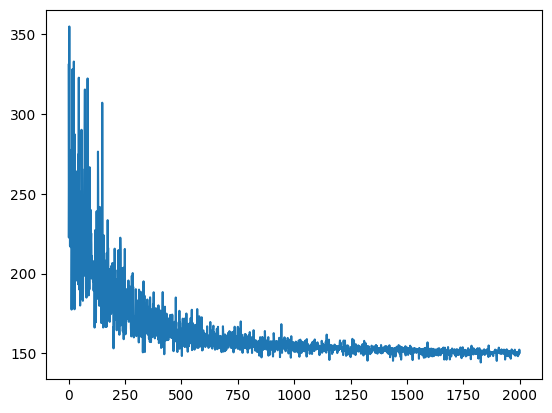

In [126]:
X = np.stack([x_real, x_spur]).T
model = MultipleRegression(tt(X), tt(y))
loss = model.train(2000)
plt.plot(loss) 
plt.show()

In [127]:
samples = {k: v.detach().numpy() for k, v in Predictive(model, guide=model.guide, num_samples=10000, return_sites=("beta",))().items()}
beta = samples["beta"][:,0, 0].mean()
q1, q2 = HPDI(samples["beta"][:,0, 0], 0.89)
print(f"x_real coefficient: {beta:.2f}; [{q1:.2f}, {q2:.2f}]")
beta = samples["beta"][:,0, 1].mean()
q1, q2 = HPDI(samples["beta"][:,0, 1], 0.89)
print(f"x_spur coefficient: {beta:.2f}; [{q1:.2f}, {q2:.2f}]")

x_real coefficient: 1.07; [0.91, 1.24]
x_spur coefficient: 0.06; [-0.08, 0.19]


### Code 5.19 - 5.22 (also 5.24 - 5.26)
Run two simultaneous regressions to estimate the influence of A on both M and D through the DAG (A -> M -> D, A -> D). Create counterfactual plots showing how manipulating A influences M and D.

In [128]:
class CausalModel:
    def __init__(self, A, M, D):
        # Cache data
        self.A = A
        self.M = M
        self.D = D
        # Initialize priors
        self.prior = {
            "aM": Normal(*tt((0., 0.2)).double()),
            "bAM": Normal(*tt((0., 0.5)).double()),
            "σM": Exponential(tt(1.).double()),
            "a": Normal(*tt((0., 0.2)).double()),
            "bM": Normal(*tt((0., 0.5)).double()),
            "bA": Normal(*tt((0., 0.5)).double()),
            "σ": Exponential(tt(1.).double()),
        }
        
    def __call__(self, A=None):
        c = {k: pyro.sample(k, dist) for k, dist in self.prior.items()}
        if A is None:
            # First regress M
            mu_M = pyro.deterministic("μM", c["aM"] + c["bAM"]*self.A)
            with pyro.plate("N_M", len(self.M)):
                M = pyro.sample("M", Normal(mu_M, c["σM"]), obs=self.M)
            # Then use M regression to predict D
            mu = pyro.deterministic("μ", c["a"] + c["bM"]*M + c["bA"]*self.A)
            with pyro.plate("N_D", len(self.D)):
                pyro.sample("D", Normal(mu, c["σ"]), obs=self.D)
        else:
            mu_M = pyro.deterministic("μM", c["aM"] + c["bAM"]*A)
            M = pyro.sample("M", Normal(mu_M, c["σM"]))
            mu = pyro.deterministic("μ", c["a"] + c["bM"]*M + c["bA"]*A)
            return pyro.sample("D", Normal(mu, c["σ"]))
        
    def fit(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self)
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = list()
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

  0%|          | 0/2000 [00:00<?, ?it/s]

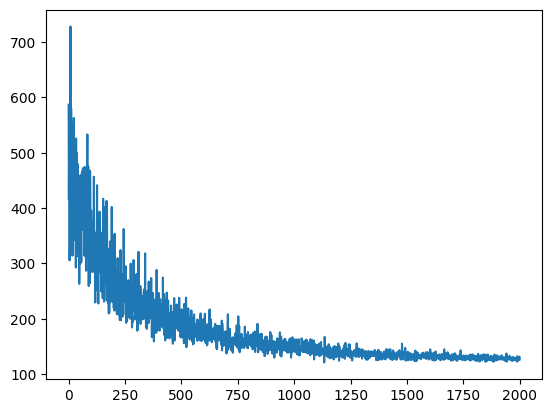

In [129]:
m5_3_A = CausalModel(tt(wdata.As), tt(wdata.Ms), tt(wdata.Ds))
loss = m5_3_A.fit(2000)
plt.plot(loss); plt.show()

In [130]:
# sample from the posterior for μM while conditioning on M
samples = {k: v.detach().numpy() for k, v in Predictive(m5_3_A, guide=m5_3_A.guide, num_samples=100)().items()}

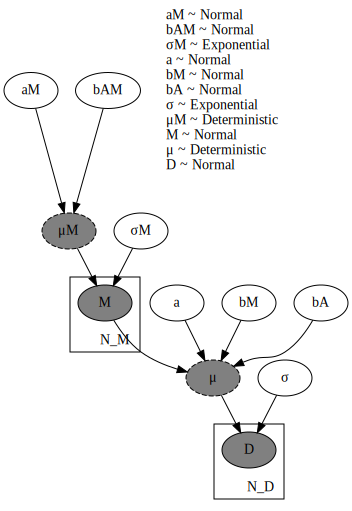

In [131]:
pyro.render_model(m5_3_A, 
                  model_args=(),     
                  render_params=True,
                  render_distributions=True,
                  render_deterministic=True)

torch.Size([50])


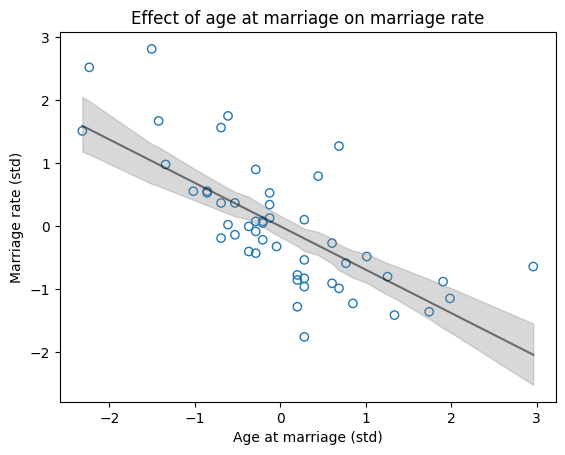

In [132]:
# data
plt.scatter(m5_3_A.A, m5_3_A.M, facecolor="none", edgecolor="C0")
# HPDI
idx = np.argsort(m5_3_A.A)
print(idx.shape)
hpdi = np.stack([HPDI(s, 0.89) for s in samples["μM"].squeeze().T])
plt.fill_between(m5_3_A.A[idx], *hpdi[idx].T, color="grey", alpha=0.3)
# mean regression line
mu = samples["μM"].reshape(samples["μM"].shape[0], samples["μM"].shape[-1]).mean(axis=0)
plt.plot(m5_3_A.A[idx], mu[idx], color="black", alpha=0.5)
# labels n' shit
plt.xlabel("Age at marriage (std)")
plt.ylabel("Marriage rate (std)")
plt.title("Effect of age at marriage on marriage rate")
plt.show()


In [133]:
# intervene on A and sample from posterior (without conditioning on M)
a = torch.linspace(-2, 2, 30)
samples = {k: v.detach().numpy() for k, v in Predictive(m5_3_A, guide=m5_3_A.guide, num_samples=10000)(a).items()}

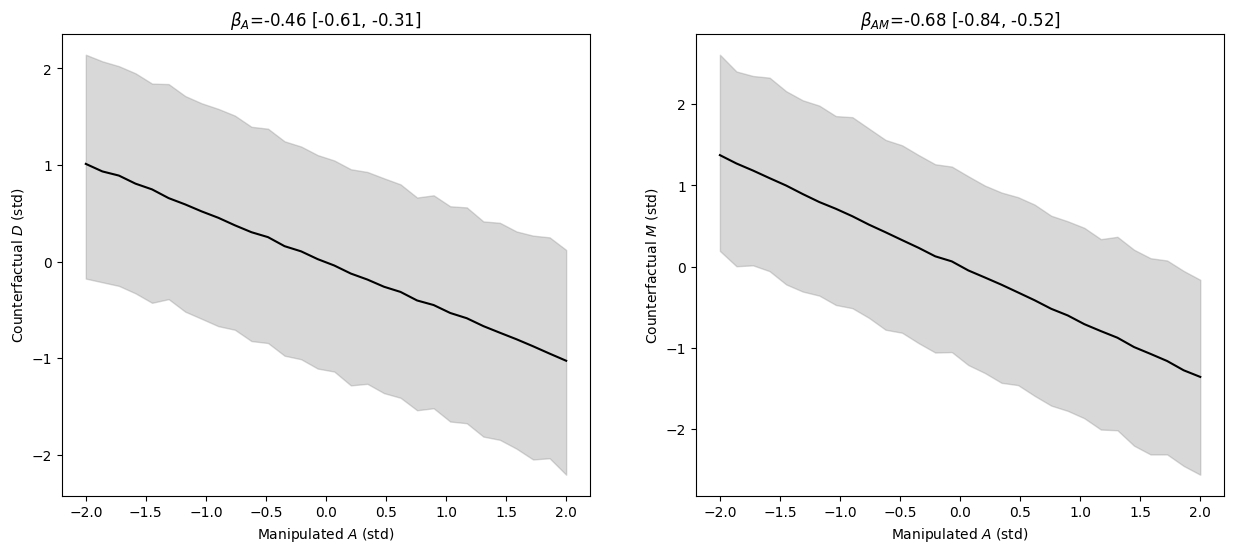

In [134]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# counterfactual effect of A on D
d = samples["D"].mean(axis=0)
hpdi = np.stack([HPDI(s, 0.89) for s in samples["D"].T])
plt.sca(axes[0])
plt.fill_between(a, *hpdi.T, color="gray", alpha=0.3)
plt.plot(a, d, color="black")
plt.xlabel("Manipulated $A$ (std)")
plt.ylabel("Counterfactual $D$ (std)")
ba = samples["bA"].mean()
q1, q2 = HPDI(samples["bA"], 0.89)
plt.title(r"$\beta_A$="f"{ba:.2f} [{q1:.2f}, {q2:.2f}]")
# counterfactual effect of A on M
m = samples["M"].mean(axis=0)
hpdi = np.stack([HPDI(s, 0.89) for s in samples["M"].T])
plt.sca(axes[1])
plt.fill_between(a, *hpdi.T, color="gray", alpha=0.3)
plt.plot(a, m, color="black")
plt.xlabel("Manipulated $A$ (std)")
plt.ylabel("Counterfactual $M$ (std)")
bam = samples["bAM"].mean()
q1, q2 = HPDI(samples["bAM"], 0.89)
plt.title(r"$\beta_{AM}$="f"{bam:.2f} [{q1:.2f}, {q2:.2f}]")
plt.show()

### Code 5.23
Run the same analysis as above, but now look at intervention on $M$, not $A$. This breaks the effect of $A$ on $M$ in the DAG, so we only have the collider (A -> D <- M)

The trick with simulating counterfactuals is to realize that when we manipulate some variable X, we break the causal influence of other variables on X. This is the same as saying we modify the DAG so that no arrows enter X. Suppose for example that we now simulate the effect of manipulating M. This implies the DAG:

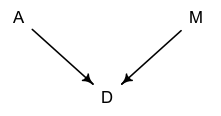

We don’t simulate A, because M doesn’t influence it.

In [135]:
class CausalModel:
    def __init__(self, A, M, D):
        # Cache data
        self.A = A
        self.M = M
        self.D = D
        # Initialize priors
        self.prior = {
            "a": Normal(*tt((0., 0.2)).double()),
            "bM": Normal(*tt((0., 0.5)).double()),
            "bA": Normal(*tt((0., 0.5)).double()),
            "σ": Exponential(tt(1.).double()),
        }
        
    def __call__(self, A=None, M=None):
        c = {k: pyro.sample(k, dist) for k, dist in self.prior.items()}
        if A is None or M is None:
            mu = pyro.deterministic("μ", c["a"] + c["bM"]*self.M + c["bA"]*self.A)
            with pyro.plate("N_D", len(self.D)):
                pyro.sample("D", Normal(mu, c["σ"]), obs=self.D)
        elif A is not None and M is not None:
            mu = pyro.deterministic("μ", c["a"] + c["bM"]*M + c["bA"]*A)
            return pyro.sample("D", Normal(mu, c["σ"]))
        else:
            raise ValueError("A and M must both either be None or not None")
        
    def fit(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self)
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = list()
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

  0%|          | 0/2000 [00:00<?, ?it/s]

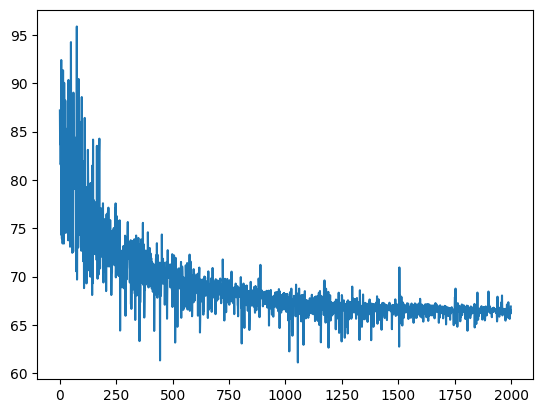

In [136]:
m5_3_M = CausalModel(tt(wdata.As), tt(wdata.Ms), tt(wdata.Ds))
loss = m5_3_M.fit(2000)
plt.plot(loss); plt.show()

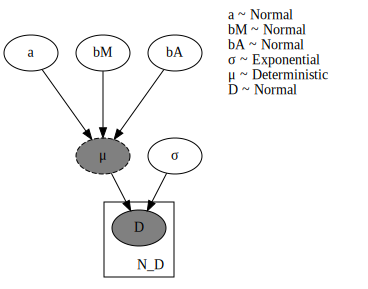

In [137]:

pyro.render_model(m5_3_M, 
                  model_args=(),     
                  render_params=True,
                  render_distributions=True,
                  render_deterministic=True)

In [138]:
# intervene on both A and M and sample from posterior
a = torch.zeros(30)
m = torch.linspace(-2, 2, 30)
samples = {k: v.detach().numpy() for k, v in Predictive(m5_3_M, guide=m5_3_M.guide, num_samples=10000)(a, m).items()}

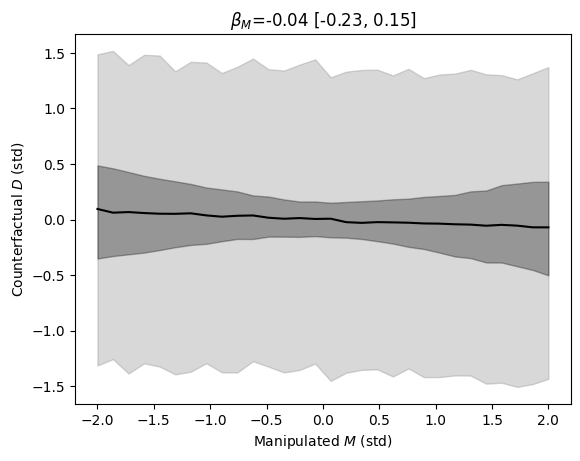

In [139]:
# counterfactual effect of M on D
d = samples["D"].mean(axis=0)
hpdi = np.stack([HPDI(s, 0.89) for s in samples["D"].T])
plt.fill_between(m, *hpdi.T, color="gray", alpha=0.3)
hpdi = np.stack([HPDI(s, 0.89) for s in samples["μ"].T])
plt.fill_between(m, *hpdi.T, color="black", alpha=0.3)
plt.plot(m, d, color="black")
plt.xlabel("Manipulated $M$ (std)")
plt.ylabel("Counterfactual $D$ (std)")
bM = samples["bM"].mean()
q1, q2 = HPDI(samples["bM"], 0.89)
plt.title(r"$\beta_M$="f"{bM:.2f} [{q1:.2f}, {q2:.2f}]")
plt.show()

Bonus: plot the joint distribution of $\beta_A$ and $\beta_M$. You can see that they are pretty strongly positively correlated, which makes sense: $\beta_A$ is pretty solidly negative, so increasing it decreases its _magnitude_, which lowers the effect of $A$ on $D$. This means that $\beta_M$ has to increase to make up for the lack of influence on $D$

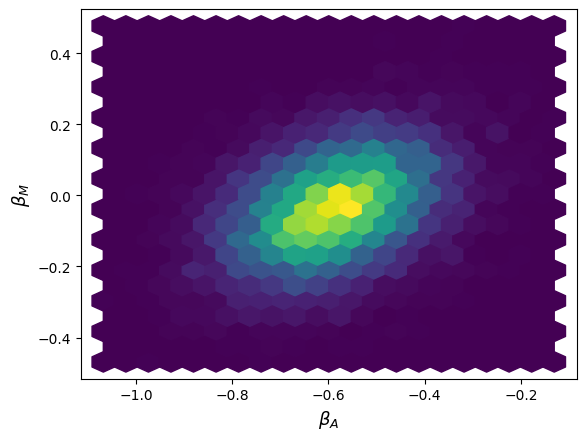

In [140]:
plt.hexbin(samples["bA"], samples["bM"], gridsize=20)
plt.xlabel(r"$\beta_A$", fontsize=13)
plt.ylabel(r"$\beta_M$", fontsize=13)
plt.show()

### Code 5.27
Now we're going to start looking at a different dataset about milk in various mammal species.

In [181]:
milk_df = pd.read_csv("data/milk.csv", sep=";")
print(f"{len(milk_df)} rows")
milk_df.sample(5)

29 rows


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
20,Ape,Nomascus concolor,0.48,15.96,12.52,71.52,7.59,NaN
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
15,Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,1.55,69.97
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64


In [182]:
milk_df[["species", "kcal.per.g", "mass", "neocortex.perc"]].sample(5)

,species,kcal.per.g,mass,neocortex.perc
16,M fuscata,0.72,7.08,NaN
27,P troglodytes,0.55,33.11,76.30
25,G gorilla beringei,0.53,97.72,NaN
19,Papio spp,0.84,12.30,73.40
28,Homo sapiens,0.71,54.95,75.49


In [142]:
milk_df.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000000,29.000000,29.000000,29.000000,29.000000,17.000000
mean,0.641724,33.990345,16.403448,49.606207,14.726897,67.575882
std,0.161402,14.286670,4.846878,14.055174,24.770469,5.968612
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000
25%,0.490000,21.220000,13.000000,37.800000,1.620000,64.540000
50%,0.600000,36.840000,15.800000,48.640000,3.470000,68.850000
75%,0.730000,46.080000,20.770000,60.120000,10.720000,71.260000
max,0.970000,55.510000,25.300000,71.910000,97.720000,76.300000


In [143]:
class MilkDataset:
    def __init__(self, df):
        self.K = df["kcal.per.g"].values
        self.N = df["neocortex.perc"].values
        self.M = np.log(df["mass"].values)
        self.num_data_pts = len(df)
        # standardize data
        self.params = {
            **{f"{k}_mean": getattr(self, k)[~np.isnan(getattr(self, k))].mean() for k in list("KNM")},
            **{f"{k}_std": getattr(self, k)[~np.isnan(getattr(self, k))].std() for k in list("KNM")},
        }
        for k in list("KNM"):
            setattr(self, k+"s", self.standardize(getattr(self, k), k))
        
    def standardize(self, x, name):
        return (x - self.params[f"{name}_mean"])/self.params[f"{name}_std"]
    
    @lru_cache()
    def non_null_idx(self, names=None):
        if names is None:
            names = list("KNM")
        if isinstance(names, str):
            names = [names]
        mask = np.ones(self.num_data_pts).astype(bool)
        for name in names:
            mask &= ~np.isnan(getattr(self, name))
        return mask

mdata = MilkDataset(milk_df)

### Code 5.29 - 5.32
Make a simple regression model and train it on the non-null data

In [144]:
class VagueRegressionModel:
    def __init__(self, N, K):
        self.N = N
        self.K = K
        # Priors
        self.a_prior = Normal(*tt((0., 1.)))
        self.bN_prior = Normal(*tt((0., 1.)))
        self.sigma_prior = Exponential(tt(1.))
        
    def __call__(self, N=None):
        a = pyro.sample("a", self.a_prior)
        bN = pyro.sample("bN", self.bN_prior)
        sigma = pyro.sample("sigma", self.sigma_prior)
        if N is None:
            mu = pyro.deterministic("mu", a + bN*self.N)
            with pyro.plate("N_K", len(self.K)):
                pyro.sample("K", Normal(mu, sigma), obs=self.K)
        else:
            mu = pyro.deterministic("mu", a + bN*N)
            return pyro.sample("K", Normal(mu, sigma))
        
    def train(self, num_samples):
        self.guide = AutoMultivariateNormal(self)
        pyro.clear_param_store()
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_samples):
            loss.append(svi.step())
        return loss

  0%|          | 0/2000 [00:00<?, ?it/s]

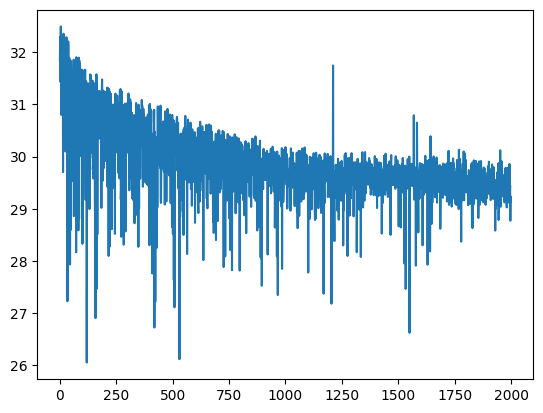

In [145]:
idx = mdata.non_null_idx(("Ns", "Ks"))
x = tt(mdata.Ns[idx])
y = tt(mdata.Ks[idx])
m5_5 = VagueRegressionModel(x, y)
loss = m5_5.train(2000)
plt.plot(loss); plt.show()

### Code 5.33
Sample from the prior to check and see if the model is reasonable

In [146]:
samples = {k: v.detach().numpy() for k, v in Predictive(m5_5, {}, num_samples=50, return_sites=("a", "bN"))().items()}

Text(0, 0.5, 'kilocal/g (std)')

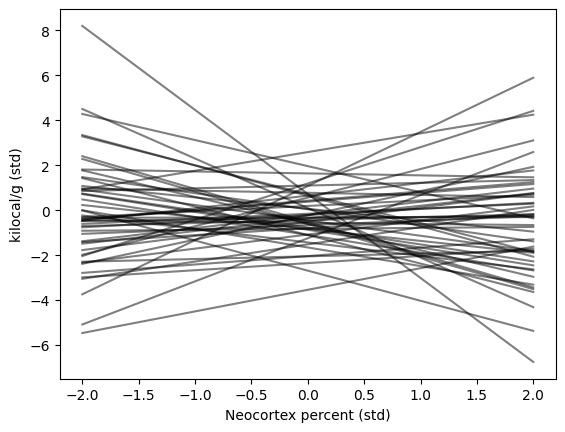

In [147]:
for a, bN in zip(*(samples[k] for k in ("a", "bN"))):
    N = np.linspace(-2, 2)
    K = a + bN*N
    plt.plot(N, K, color="black", alpha=0.5)
plt.xlabel("Neocortex percent (std)")
plt.ylabel("kilocal/g (std)")

### Code 5.34
Use slightly less vauge/silly priors

  0%|          | 0/2000 [00:00<?, ?it/s]

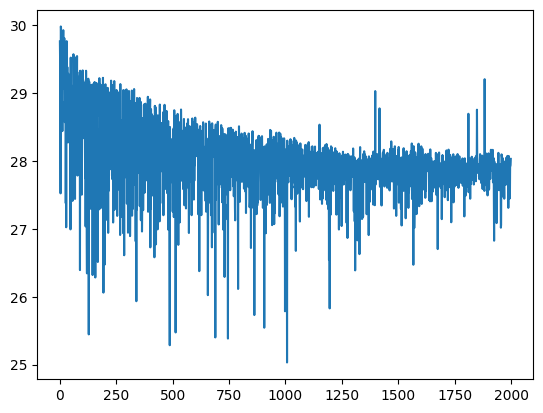

In [148]:
idx = mdata.non_null_idx(("Ns", "Ks"))
x = tt(mdata.Ns[idx])
y = tt(mdata.Ks[idx])
m5_5 = RegressionModel(x, y)
loss = m5_5.train(2000)
plt.plot(loss); plt.show()

In [149]:
samples1 = {k: v.detach().numpy() for k, v in Predictive(m5_5, {}, num_samples=50, return_sites=("alpha", "beta"))().items()}

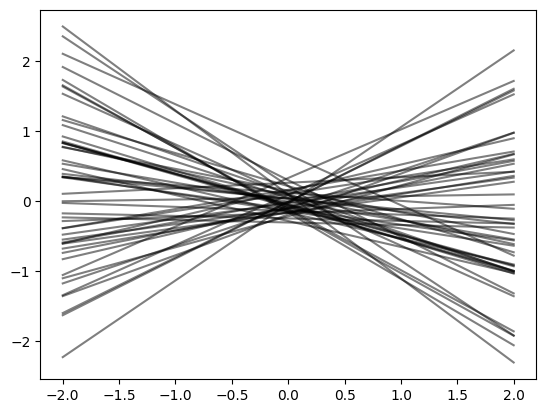

In [150]:
for a, bN in zip(*(samples1[k] for k in ("alpha", "beta"))):
    N = np.linspace(-2, 2)
    K = a + bN*N
    plt.plot(N, K, color="black", alpha=0.5)

### Code 5.35 - 5.36
Look at the posterior

In [151]:
names = {"alpha": "a", "beta": "bN"}
samples1 = {names.get(k, k): v.detach().numpy() for k, v in Predictive(m5_5, guide=m5_5.guide, num_samples=1000, return_sites=("alpha", "beta", "sigma"))().items()}
[samples1[x].shape for x in samples1.keys()]

[(1000, 1), (1000, 1), (1000, 1)]

In [152]:
precis(samples1)

,mean,stddev,5.5%,94.5%
a,0.034811,0.159278,-0.218348,0.279392
bN,0.143128,0.218506,-0.186141,0.491656
sigma,1.116246,0.190293,0.827841,1.443953


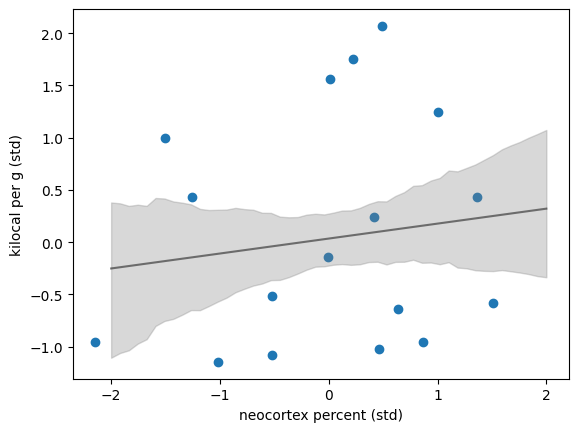

In [153]:
N = np.linspace(-2, 2)
mu = samples1["a"][:,None] + samples1["bN"][:,None]*N[:, None]
mu = mu.squeeze()
hpdi = np.stack([HPDI(s, 0.89) for s in mu.T]).T
plt.scatter(mdata.Ns, mdata.Ks)
plt.fill_between(N, *hpdi, color="gray", alpha=0.3)
plt.plot(N, mu.mean(axis=0), color="black", alpha=0.5)
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.show()

### Code 5.37
Construct a model using the (log) mass of the female

  0%|          | 0/2000 [00:00<?, ?it/s]

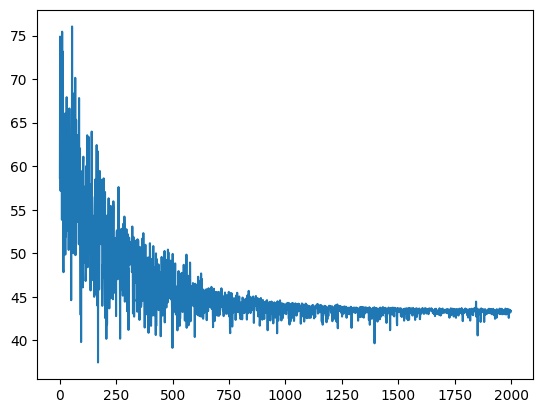

In [154]:
idx = mdata.non_null_idx(("Ms", "Ks"))
x = tt(mdata.Ms[idx])
y = tt(mdata.Ks[idx])
m5_6 = RegressionModel(x, y)
loss = m5_6.train(2000)
plt.plot(loss); plt.show()

In [155]:
names = {"alpha": "a", "beta": "bM"}
samples2 = {names.get(k, k): v.detach().numpy() for k, v in Predictive(m5_6, guide=m5_6.guide, num_samples=1000, return_sites=("alpha", "beta", "sigma"))().items()}

In [156]:
precis(samples2)

,mean,stddev,5.5%,94.5%
a,0.008483,0.126208,-0.188745,0.206282
bM,-0.297316,0.153335,-0.529518,-0.060523
sigma,0.98323,0.108557,0.826825,1.160524


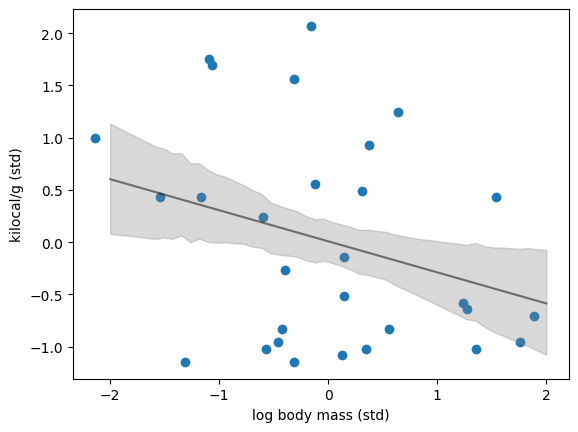

In [157]:
M = np.linspace(-2, 2)
mu = samples2["a"][:,None] + samples2["bM"][:,None] * M[None,:]
mu = mu.squeeze()
hpdi = np.stack([HPDI(s, 0.89) for s in mu.T]).T
plt.scatter(mdata.Ms, mdata.Ks)
plt.fill_between(N, *hpdi, color="gray", alpha=0.3)
plt.plot(N, mu.mean(axis=0), color="black", alpha=0.5)
plt.xlabel("log body mass (std)")
plt.ylabel("kilocal/g (std)")
plt.show()

### Code 5.38
Now do a multiple regression on $K$ with both $M$ and $N$ as predictors

  0%|          | 0/3000 [00:00<?, ?it/s]

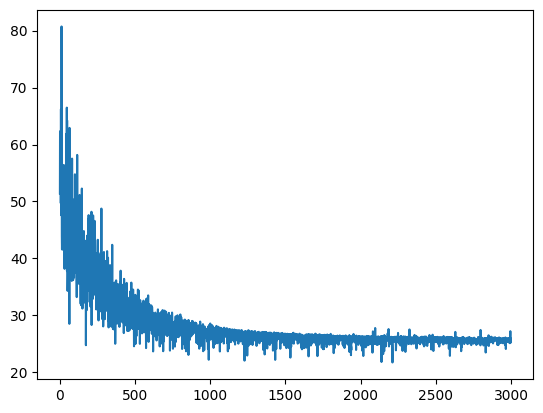

In [158]:
idx = mdata.non_null_idx()
X = tt([mdata.Ns[idx], mdata.Ms[idx]]).T.double()
y = tt(mdata.Ks[idx])
m5_7 = MultipleRegression(X, y)
loss = m5_7.train(3000)
plt.plot(loss); plt.show()

### Code 5.39
Sample from the posterior, then create a plot comparing the regression coefficients from the 3 models

In [159]:
samples3 = {k: v.detach().numpy() for k, v in Predictive(m5_7, guide=m5_7.guide, return_sites=("alpha", "beta", "sigma"), num_samples=5000)().items()}
samples3["bN"] = samples3["beta"].squeeze()[:,0]
samples3["bM"] = samples3["beta"].squeeze()[:,1]
del samples3["beta"]

In [160]:
precis(samples3)

,mean,stddev,5.5%,94.5%
alpha,0.055939,0.137484,-0.16251,0.27128
sigma,0.861106,0.13919,0.659163,1.101797
bN,0.620357,0.213652,0.280445,0.965727
bM,-0.648675,0.212521,-0.990201,-0.307983


In [161]:
summary = {
    5: {
        "bN": {
            "hpdi": HPDI(samples1["bN"], 0.89),
            "mean": samples1["bN"].mean(),
        },
        "bM": None,
    },
    6: {
        "bM": {
            "hpdi": HPDI(samples2["bM"], 0.89),
            "mean": samples2["bM"].mean(),
        },
        "bN": None,
    },
    7: {
        "bN": {
            "hpdi": HPDI(samples3["bN"], 0.89),
            "mean": samples3["bN"].mean(),
        },
        "bM": {
            "hpdi": HPDI(samples3["bM"], 0.89),
            "mean": samples3["bM"].mean(),
        },
    },
}

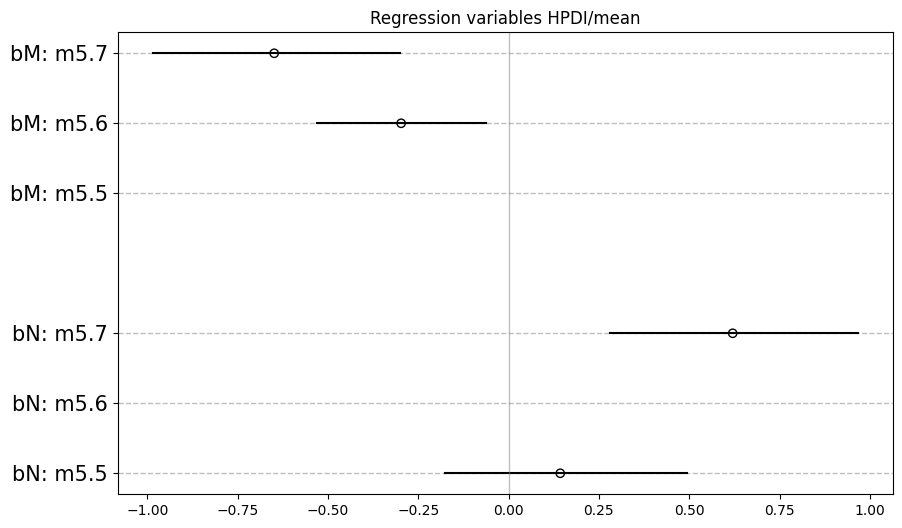

In [162]:
plt.figure(figsize=(10, 6))
ticks = list()
for i, model in summary.items():
    for var, vals in model.items():
        if var == "bM":
            y = i + 4
        else:
            y = i
        plt.axhline(y, color="gray", linestyle="--", linewidth=1, alpha=0.5)
        ticks.append((y, f"{var}: m5.{i}"))
        if vals is None: continue
        for k, v in vals.items():
            if k == "mean":
                plt.scatter(v, y, facecolor="none", edgecolor="black")
            elif k == "hpdi":
                plt.plot(v, [y, y], color="black")
plt.axvline(0, color="gray", linewidth=1, alpha=0.5)
plt.yticks(*zip(*ticks), fontsize=15)
plt.title("Regression variables HPDI/mean")
plt.show()

Bonus: here are the potential DAGs that could explain the patterns in this data. ($U$ is an "unknown" factor)

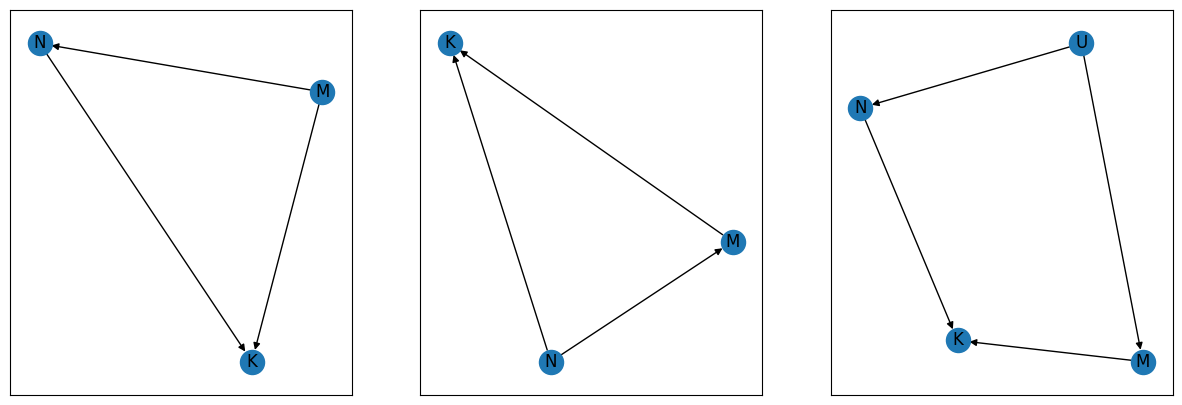

In [163]:
G1 = nx.DiGraph([("M", "N"), ("M", "K"), ("N", "K")])
G2 = nx.DiGraph([("N", "M"), ("M", "K"), ("N", "K")])
G3 = nx.DiGraph([("U", "M"), ("U", "N"), ("M", "K"), ("N", "K")])
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for G, ax in zip((G1, G2, G3), axes):
    plt.sca(ax)
    nx.draw_networkx(G)
plt.show()

In [164]:
print("conditional independencies:")
for i, G in enumerate((G1, G2, G3)):
    ci = conditional_independencies(G)
    ci = [f"{n1} \u27c2 {n2} | {n3}" for n1, n2, n3 in ci]
    print(f"\tG{i}: {ci}")

conditional independencies:
	G0: []
	G1: []
	G2: ['M ⟂ N | U']


### Code 5.40
Make counterfactual plots showing the effect of intervention on $M$ and $N$

In [165]:
samples3.keys()

dict_keys(['alpha', 'sigma', 'bN', 'bM'])

(5000, 50)


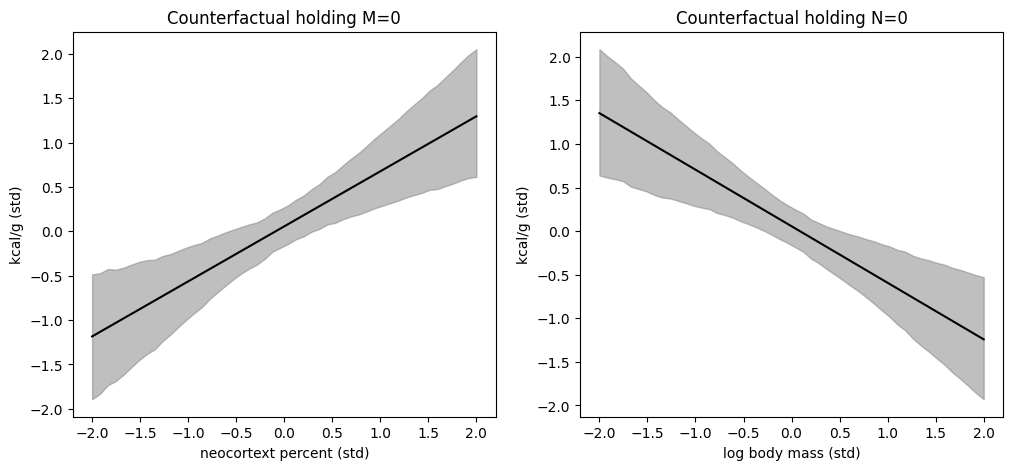

In [166]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
# neocortex percent vs kcal/g
plt.sca(axes[0])
x = np.linspace(-2, 2)
mu =  samples3["alpha"][:] + samples3["bN"][:,None] * x[None,:]
print(mu.shape)
hpdi = np.stack([HPDI(s, 0.89) for s in mu.T]).T
plt.fill_between(x, *hpdi, color="grey", alpha=0.5)
plt.plot(x, mu.mean(axis=0), color="black")
plt.xlabel("neocortext percent (std)")
plt.ylabel("kcal/g (std)")
plt.title("Counterfactual holding M=0")
# log body mass vs kcal/g
plt.sca(axes[1])
mu = samples3["alpha"][:] + samples3["bM"][:,None] * x[None,:]
hpdi = np.stack([HPDI(s, 0.89) for s in mu.T]).T
plt.fill_between(x, *hpdi, color="grey", alpha=0.5)
plt.plot(x, mu.mean(axis=0), color="black")
plt.xlabel("log body mass (std)")
plt.ylabel("kcal/g (std)")
plt.title("Counterfactual holding N=0")
plt.show()

### Code 5.44
Now we're going to start looking at categorical predictors and how to include them in models. We'll take a look at the height dataset from before and look at the influence of sex (male/female) on the heights.

In [167]:
howell_df = pd.read_csv("data/Howell1.csv", sep=";")
howell_df.sample(3)

,height,weight,age,male
526,125.095,22.594552,12.0,0
469,144.780,33.452410,42.0,0
249,146.685,36.088913,62.0,0


In [168]:
howell_df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


### Code 5.45-5.48
If we ignore other predictors and focus only on the "maleness" feature, then we can create a linear model where $\mu_i = \alpha + \beta_m m$ ($m$ is maleness). This forces us to interpret $\alpha$ as the average female height, and $\beta_m$ as the average difference between male/female heights. This is a little strange and does not put male/female heights on the same footing (since it requires two parameters to describe male height, but only one for female height). This results in more uncertainty for male heights - we can see the standard deviation of the male heights is larger than female when sampling from the prior, even though the means are the same:

In [169]:
# simulate priors using the mu = alpha + beta*m model
N = 10000
precis(dict(
    mu_female = st.norm(178, 20).rvs(N),
    mu_male = st.norm(178, 20).rvs(N) + st.norm(0, 10).rvs(N)
))

,mean,stddev,5.5%,94.5%
mu_female,178.388052,20.097863,146.302324,209.960732
mu_male,178.377419,22.434172,142.236345,214.997134


A better alternative would be to simply have a single parameter for each level of this factor, i.e. $\alpha_m$ and $\alpha_f$, and $\mu_i = \alpha_{\text{sex}[i]}$. SEX[i] denotes label-encoding the variables. Fortunately the sex is basically already label encoded.

In [170]:
class BinaryRegression:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        # priors
        self.alpha_prior = Normal(*tt((178., 20.)).double())\
            .expand([2])\
            .to_event(1)
        self.sigma_prior = Uniform(*tt((0., 50.)).double())
        
    def __call__(self, x=None):
        alpha = pyro.sample("alpha", self.alpha_prior)
        sigma = pyro.sample("sigma", self.sigma_prior)
        mu = torch.zeros_like(self.y)
        if x is None:
            mu[self.x == 1] = alpha[0]
            mu[self.x == 0] = alpha[1]
            mu = pyro.deterministic("mu", mu)
            with pyro.plate("N_h", len(self.y)):
                pyro.sample("h", Normal(mu, sigma), obs=self.y)
        else:
            mu[x == 1] = alpha[0]
            mu[x == 0] = alpha[1]
            mu = pyro.deterministic("mu", mu)
            return pyro.sample("h", Normal(mu, sigma))
        
    def train(self, num_steps):
        self.guide = AutoMultivariateNormal(self,
            init_loc_fn=init_to_mean
        )
        pyro.clear_param_store()
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-2}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

  0%|          | 0/10000 [00:00<?, ?it/s]

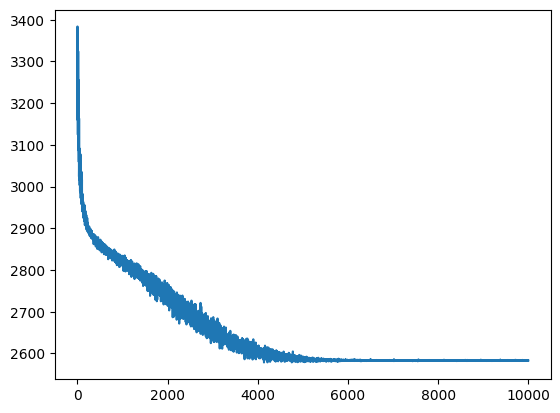

In [171]:
x = tt(howell_df["male"].values).long()
y = tt(howell_df["height"].values).double()
m5_8 = BinaryRegression(x, y)
loss = m5_8.train(10000)
plt.plot(loss); plt.show()

In [172]:
samples = {k: v.detach().numpy() for k, v in Predictive(m5_8, guide=m5_8.guide, return_sites=("alpha", "sigma"), num_samples=10000)().items()}
samples["alpha_m"] = samples["alpha"].squeeze()[:,0]
samples["alpha_f"] = samples["alpha"].squeeze()[:,1]
del samples["alpha"]
precis(samples)

,mean,stddev,5.5%,94.5%
sigma,27.365209,0.82181,26.051826,28.681292
alpha_m,142.565464,1.699587,139.843563,145.233986
alpha_f,134.732677,1.592129,132.181309,137.303561


What is the expected difference between males and females?

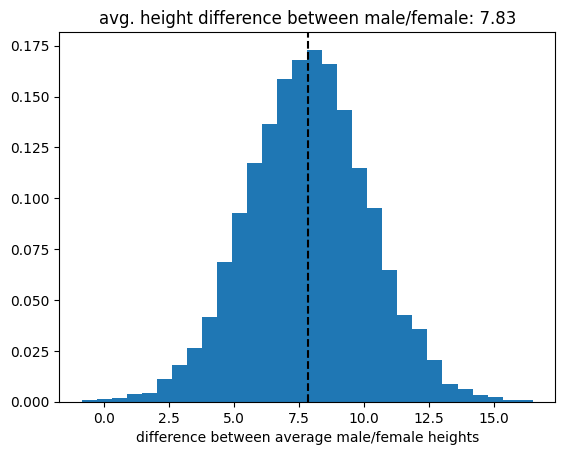

In [173]:
diff = samples["alpha_m"] - samples["alpha_f"]
plt.hist(diff, density=True, bins=30)

m = diff.mean()
plt.axvline(m, color="black", linestyle="--")
plt.xlabel("difference between average male/female heights")
plt.title(f"avg. height difference between male/female: {m:.2f}")
plt.show()

### Code 5.49 - 5.50
Now let's take a look at the milk dataset again. There is a "clade" feature, which is a categorical variable related to the species

In [174]:
class MilkDataset:
    def __init__(self, df):
        self.K = df["kcal.per.g"].values
        self.N = df["neocortex.perc"].values
        self.M = np.log(df["mass"].values)
        self.C2i = {k: i for i, k in enumerate(df["clade"].unique())}
        self.i2C = {i: k for k, i in self.C2i.items()}
        self.C = np.array([self.C2i[k] for k in df["clade"]])
        self.num_data_pts = len(df)
        # standardize data
        self.params = {
            **{f"{k}_mean": getattr(self, k)[~np.isnan(getattr(self, k))].mean() for k in list("KNM")},
            **{f"{k}_std": getattr(self, k)[~np.isnan(getattr(self, k))].std() for k in list("KNM")},
        }
        for k in list("KNM"):
            setattr(self, k+"s", self.standardize(getattr(self, k), k))
        
    def standardize(self, x, name):
        return (x - self.params[f"{name}_mean"])/self.params[f"{name}_std"]
    
    @lru_cache()
    def non_null_idx(self, names=None):
        if names is None:
            names = list("KNM")
        if isinstance(names, str):
            names = [names]
        mask = np.ones(self.num_data_pts).astype(bool)
        for name in names:
            mask &= ~np.isnan(getattr(self, name))
        return mask

mdata = MilkDataset(milk_df)

In [175]:
mdata.C2i

{'Strepsirrhine': 0, 'New World Monkey': 1, 'Old World Monkey': 2, 'Ape': 3}

### Code 5.51
Do regression where each category in "clade" has its own parameter

In [183]:
class CategoricalRegression:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        # priors
        self.num_classes = len(np.unique(x))
        self.alpha_prior = Normal(*tt((0., 0.5)).double()).expand([self.num_classes]).to_event(1)
        self.sigma_prior = Exponential(tt(1.).double())
        
    def __call__(self, x=None):
        alpha = pyro.sample("alpha", self.alpha_prior)
        sigma = pyro.sample("sigma", self.sigma_prior)
        mu = torch.zeros_like(self.y)
        if x is None:
            for i in range(self.num_classes):
                mu[self.x == i] = alpha[i]
            pyro.deterministic("mu", mu)
            with pyro.plate("N_K", len(self.y)):
                pyro.sample("K", Normal(mu, sigma), obs=self.y)
        else:
            for i in range(self.num_classes):
                mu[x == i] = alpha[i]
            pyro.deterministic("mu", mu)
            return pyro.sample("K", Normal(mu, sigma))
        
    def train(self, num_steps):
        self.guide = AutoMultivariateNormal(self,
            init_loc_fn=init_to_mean
        )
        pyro.clear_param_store()
        svi = SVI(self, self.guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

  0%|          | 0/5000 [00:00<?, ?it/s]

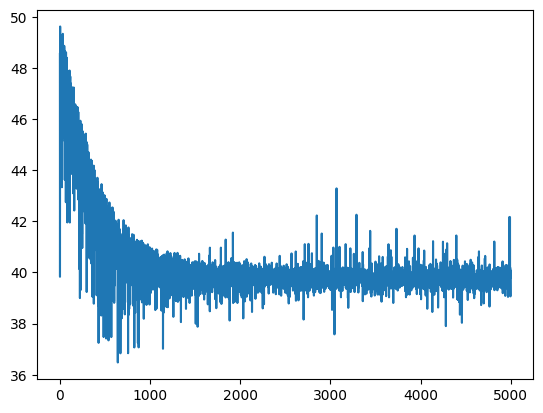

In [184]:
x = tt(mdata.C).long()
y = tt(mdata.Ks).double()
m5_9 = CategoricalRegression(x, y)
loss = m5_9.train(5000)
plt.plot(loss); plt.show()

In [185]:
samples = {k: v.detach().numpy() for k, v in Predictive(m5_9, guide=m5_9.guide, return_sites=("alpha",), num_samples=1000)().items()}

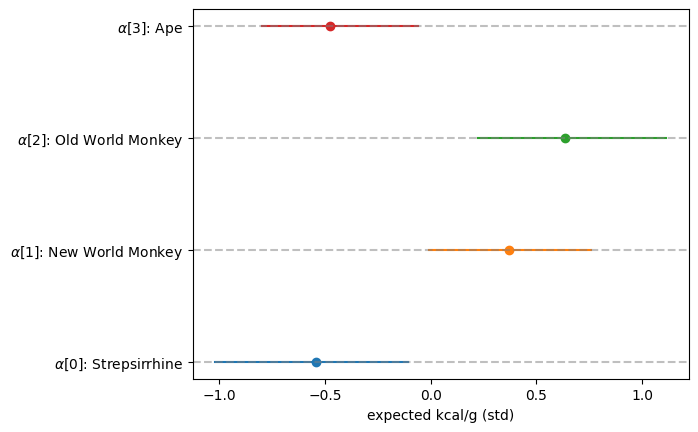

In [186]:
for i, s in enumerate(samples["alpha"].squeeze().T):
    mean = s.mean()
    hpdi = HPDI(s, 0.89)
    plt.scatter(mean, i)
    plt.plot(hpdi, [i, i])
    plt.axhline(i, color="gray", linestyle="--", alpha=0.5)
plt.yticks(*zip(*((i, r"$\alpha$"f"[{i}]: {k}") for i, k in mdata.i2C.items())))
plt.xlabel("expected kcal/g (std)")
plt.show()